[<img src="https://github.com/chrisluedtke/divvy-data-analysis/img/nbviewer.PNG">](https://nbviewer.jupyter.org/github/chrisluedtke/divvy-data-analysis/blob/master/notebook.ipynb)

In [2]:
%matplotlib inline
import folium
import pandas as pd

import divvy

### Initial Data Sourcing

In [10]:
# rides, stations = divvy.historical_data.get_data(
#     year=[str(_) for _ in range(2013,2019)],
#     rides=True, 
#     stations=True
# )

# rides.to_pickle('data/rides.pkl')
# stations.to_pickle('data/stations.pkl')

### Load from Pickle

In [43]:
rides = pd.read_pickle('data/rides.pkl')

In [10]:
stations = pd.read_pickle('data/stations.pkl')

### Exploration

In [4]:
rides.dtypes

bikeid                        int64
birthday                    float64
birthyear                   float64
end_time                     object
from_station_id               int64
from_station_name            object
gender                       object
start_time           datetime64[ns]
to_station_id                 int64
to_station_name              object
trip_id                       int64
tripduration                float64
usertype                     object
dtype: object

In [5]:
rides.isna().sum()

bikeid                      0
birthday             17022431
birthyear             4730951
end_time                    0
from_station_id             0
from_station_name           0
gender                4335754
start_time                  0
to_station_id               0
to_station_name             0
trip_id                     0
tripduration                0
usertype                    0
dtype: int64

count    6386.000000
mean     2728.678359
std       871.209718
min         2.000000
25%      2059.250000
50%      2779.500000
75%      3427.000000
max      5164.000000
Name: bikeid, dtype: float64


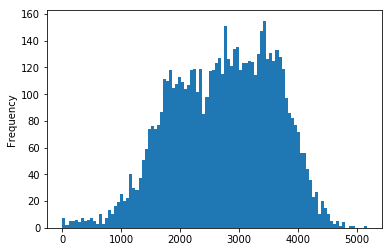

In [117]:
# How many times has each bike been ridden?
bike_use = rides['bikeid'].value_counts()
print(bike_use.describe())
bike_use.plot.hist(bins=100);

In [4]:
def get_all_groups(how='Q', start='2013-01-01', end='2018-12-31'):
    all_dates = pd.date_range(start, end, freq='D')
    all_dates = (pd.Series(all_dates)
                   .dt.to_period(how)
                   .drop_duplicates())
    
    return pd.Series(data=0, index=all_dates)

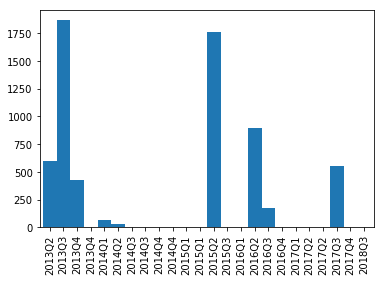

In [5]:
# Count of first month bike used
color=(31/256,119/256,180/256,1)

frst_use = (rides.groupby('bikeid')['start_time'].first()
                 .dt.to_period("Q"))
frst_use.name = 'first_use_quarter'

data = frst_use.value_counts()

data = data.append(get_all_groups(how='Q'))
data = (data.sort_values(ascending=False)
            .loc[~data.index.duplicated(keep='first')]
            .sort_index())

data.plot.bar(color=color, width=1);

In [ ]:
# color bike usage by quarter first ridden
rides = rides.merge(frst_use.astype(str), left_on='bikeid',
                    right_on=frst_use.index)

In [10]:
cols = ['first_use_quarter', 'bikeid']
bike_use = rides[cols].sort_values('first_use_quarter')

bike_use_grp = (bike_use.groupby('first_use_quarter')['bikeid'].value_counts()
                        .reset_index(name='n_rides')
                        .drop(columns='bikeid'))

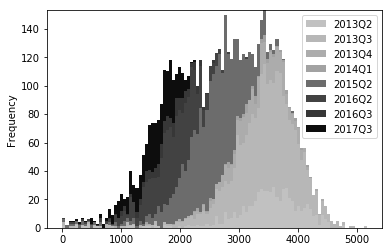

In [147]:
color_dict = {}
all_groups = get_all_groups()

for i, v in enumerate(all_groups.index):
    color_dict[str(v)] = (
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        .8-i/len(all_groups), 
        1
    )
    
colors = [color_dict.get(group) for group in bike_use_grp.first_use_quarter.unique()]

d = {}
for k, v in bike_use_grp.groupby('first_use_quarter').n_rides:
    if len(v) > 31:
        d[k] = v
        
hist = pd.DataFrame(d)

hist.plot.hist(bins=100, stacked=True, color=[color_dict[col] for col in hist.columns]);

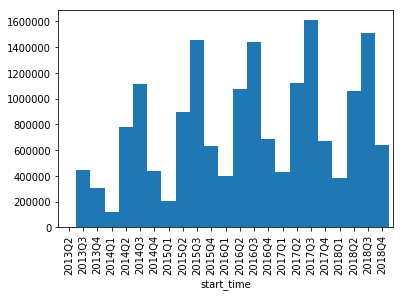

In [118]:
# Count of quarterly rides
(rides['start_time'].groupby([rides.start_time
                                   .dt.to_period("Q")])
                    .count()
                    .plot.bar(color=color, width=1));

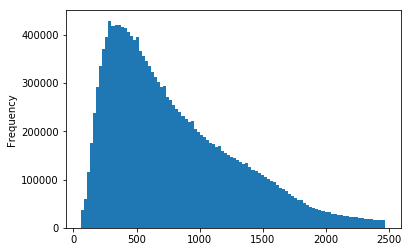

In [120]:
# How long are trips?
(rides.tripduration.loc[rides.tripduration < rides.tripduration.quantile(.95)]
                   .plot.hist(bins=100));

## Get Station Coordinates

In [3]:
stations = pd.read_pickle('data/stations.pkl')

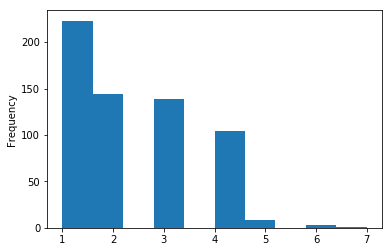

In [4]:
# Stations have moved
(stations.drop_duplicates(['id', 'latitude', 'longitude'])
         .groupby('id')['id'].count()
         .plot.hist());

Unfortunately, Divvy kept the same station ID while physically moving those stations around. This adds a lot of complexity to route analysis, and it makes certain analyses impossible.

One approach may be to round lat/lon coordinates to some [degree of precision](https://en.wikipedia.org/wiki/Decimal_degrees#Precision), and then remove duplicates on rounded position. While that may seem to reduce the problem, there would be no way to determine whether a station initially at position A, moved to position B, and then back to position A.

Another approach is to calculate the rolling difference of lat/lon coordinates and filter out differences below a desired precision. Let's do that.

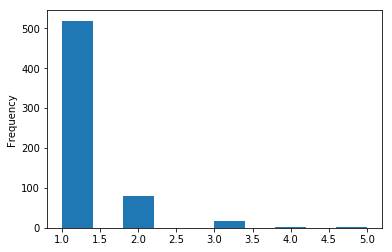

In [5]:
fix2 = stations.copy()
diffs = (fix2.groupby('id')
             .agg({'latitude':'diff',
                   'longitude':'diff'})
             .assign(sum_diff=lambda df: abs(df.latitude) + 
                                         abs(df.longitude))
             .drop(columns=['latitude', 'longitude']))

fix2 = pd.concat([fix2, diffs], axis=1)
# NaNs are first instance, so keep those
fix2 = fix2.loc[fix2.sum_diff.isna() | (fix2.sum_diff > 0.0005)]

dupe_counts = fix2.groupby('id')['id'].count()
dupe_counts.plot.hist();

We can assess the problem by calculating the variance and distance of moved stations:

In [6]:
variance = (fix2.groupby('id')['latitude', 'longitude']
                .agg(lambda df: df.latitude.var() + df.latitude.var())
                .rename(columns={'latitude':'sum_var'})
                .drop(columns='longitude')
                .sort_values('sum_var', ascending=False))

dist = (fix2.groupby('id')['latitude', 'longitude']
            .agg(lambda df: (
                abs(df.latitude.max() - df.latitude.min())**2 +
                abs(df.longitude.max() - df.longitude.min())**2) ** (1/2))
            .rename(columns={'latitude':'dist'})
            .drop(columns='longitude')
            .sort_values('dist', ascending=False))

print(variance.head(), dist.head(), sep='\n\n')

      sum_var
id           
414  0.000275
2    0.000038
315  0.000038
311  0.000009
114  0.000006

         dist
id           
315  0.019616
414  0.017154
2    0.009903
163  0.007066
372  0.006491


In [22]:
df = fix2.loc[fix2.id.duplicated(keep=False), 
              ['id', 'latitude', 'longitude', 
               'online_date', 'source']]

m = folium.Map(location=[df.latitude.mean(), 
                         df.longitude.mean()],
               tiles='Stamen Terrain',
               zoom_start=12)

grouped = df.groupby('id')
for k, v in grouped:
    points = list(zip(v.latitude, v.longitude))
    folium.PolyLine(
        points, tooltip=str(v.id.values[0])
    ).add_to(m)
m

From here I would create a lookup table for stations that have moved. The rows would span each day the station was active, and I would merge with my `rides` table on a `ride_id_date` key. Here's the start to that process:

In [18]:
# station_dates = pd.concat([rides[['start_time', 'to_station_id']].rename(columns={'to_station_id':'station_id'}), 
#                            rides[['start_time', 'from_station_id']].rename(columns={'from_station_id':'station_id'})], 
#                           ignore_index=True)

# station_dates = (station_dates.sort_values('start_time')
#                               .groupby('station_id')
#                               .agg({'start_time':['min', 'max']}))

But for now, I'll average each duplicated station's lat/lon positions to make things easy.

In [96]:
stations = (fix2.groupby('id')['latitude', 'longitude']
                .mean().reset_index())

In [20]:
connections = (df.groupby(['from_station_id','to_station_id'])
                 .agg({'trip_id':'count'}))

In [36]:
# Using google maps, I would have to filter to routes that have >35 
# rides in order for it to be free-ish
cutoff = 35
(len(connections.loc[connections['trip_id'] > cutoff]) - 40000) * 0.005 #cents/query

2.57

https://developers.google.com/maps/documentation/directions/start

https://developers.google.com/maps/billing/understanding-cost-of-use#directions

https://developers.google.com/maps/documentation/directions/intro#TravelModes